# RNN BUILD
Bygger og tester ut RNN modeller

In [75]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens
from lib.create_dataset import create_dataset

In [2]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_15_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma15_derivert'] = [stock.open_15_sma[i] / stock.open_15_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_15_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        #evaluate_trades(stock)
        #break # må tas bort ettervært
        stocks.append(stock)
    
    return stocks

    
def add_data(word):
    ordet = 'data/' + word
    return ordet

In [110]:
filer = list(map(add_data, os.listdir('data/')))[16:20] # test 54:60
data = make_ready(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [111]:
dataxes = []
datayes = []
sanne = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.extend(datax)
    datayes.extend(datay)
    sanne.append(sann)
    
dataxes = np.array(dataxes)
datayes = np.array(datayes)


In [112]:
state = np.random.get_state()
np.random.shuffle(dataxes)
np.random.set_state(state)
np.random.shuffle(datayes)

In [113]:
model = Sequential()

model.add(LSTM(units=256, input_shape=(30, 5), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 30, 256)           268288    
_________________________________________________________________
dropout_26 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 796,170
Trainable params: 796,170
Non-trainable params: 0
_________________________________________________________________


In [114]:
print(datayes.shape)
print(dataxes.shape)

(1162, 10)
(1162, 30, 5)


In [107]:
y

array([[-0.09747045, -0.07798092, -0.09748071, ...,  0.01950002,
         0.        , -0.01949979],
       [-0.0975823 , -0.11710562, -0.0780759 , ..., -0.0780887 ,
        -0.09761545, -0.13666963],
       [-0.09731621, -0.07785752, -0.03893058, ..., -0.17523057,
        -0.21419322, -0.22395806],
       ...,
       [ 0.01950755,  0.01950732,  0.03901419, ...,  0.03900917,
         0.05851238,  0.07801377],
       [-0.13611474, -0.13612586, -0.17503326, ..., -0.35029542,
        -0.33090411, -0.29203219],
       [ 0.03888312,  0.11664664,  0.05831924, ...,  0.01943521,
        -0.09717493,  0.05830836]])

In [115]:
history = model.fit(dataxes, datayes, epochs=3, batch_size=256, verbose=1)

Train on 1162 samples
Epoch 1/3
1162/1162 [==============================] - 15s 13ms/sample - loss: 0.2336
Epoch 2/3
1162/1162 [==============================] - 6s 5ms/sample - loss: 0.1664
Epoch 3/3
1162/1162 [==============================] - 6s 5ms/sample - loss: 0.1480


In [109]:
model.predict(dataxes[0])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

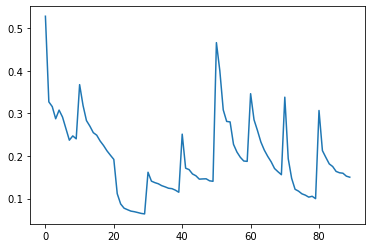

In [265]:
#plt.plot(history.history['loss'])
flatten = [j for sub in all_history for j in sub]
#all_history
#for h in all_history:
plt.plot(flatten)

In [270]:
predicts = []
for i in dataxes:
    predict = model.predict(i)
    predicts.append(predict)

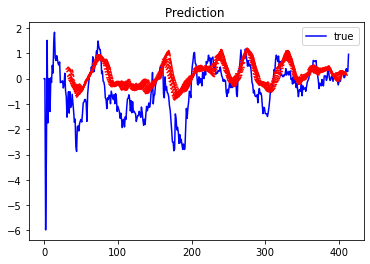

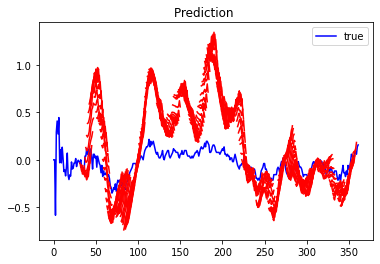

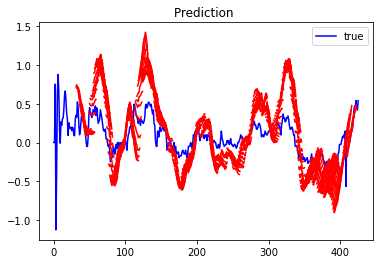

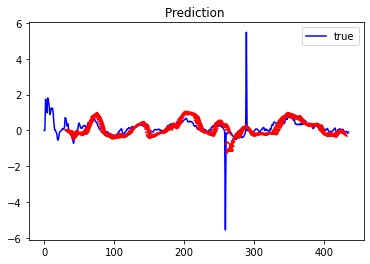

In [271]:
for j in range(len(dataxes)):
    plt.plot(sanne[j], c='blue', label='true')
    for i in range(len(datayes[j])):
        plt.plot(range(i+look_back,i+look_back+look_forward), predicts[j][i], c='red')

    plt.legend()
    plt.title('Prediction ')
    #plt.savefig('images/RNN_15_ahead')
    plt.show()


In [214]:
predict[0]

array([0.69334054, 0.5858242 , 0.57565075, 0.50590146, 0.5145738 ,
       0.5676173 , 0.4426812 , 0.4868359 , 0.5041089 , 0.50749564],
      dtype=float32)

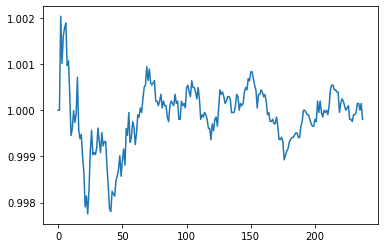

In [250]:
plt.plot(data[0].sma15_derivert)
#plt.plot(data.sma5_derivert)

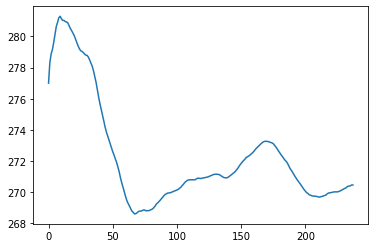

In [253]:
plt.plot(data[0].open_30_sma)
#plt.plot(data.sma5_derivert)

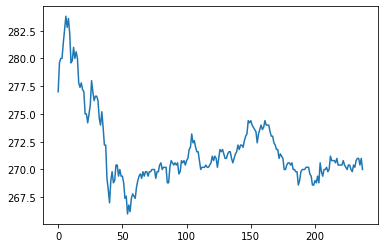

In [252]:
plt.plot(data[0].open)
#plt.plot(data.sma5_derivert)

In [272]:
# Save model

model.save('rnn_model.h5')

In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
